,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


train shape: (1458644, 11) | test shape: (625134, 9)

Dtypes train:
id                            object
vendor_id                      int64
pickup_datetime       datetime64[ns]
dropoff_datetime              object
passenger_count                int64
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
store_and_fwd_flag            object
trip_duration                  int64
dtype: object


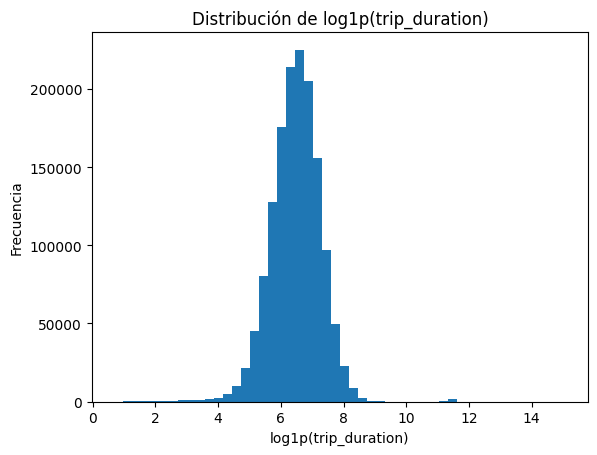

In [1]:
# Celda 1: Carga + checks mínimos (sin ifs)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# Rutas fijas (usa / para evitar problemas en Windows)
train = pd.read_csv("datasets\\train\\train.csv")
test  = pd.read_csv("datasets\\test\\test.csv")
sample = pd.read_csv("datasets\sample_submission\sample_submission.csv")

# Fechas (solo lo que vamos a usar)
train["pickup_datetime"] = pd.to_datetime(train["pickup_datetime"])
test["pickup_datetime"]  = pd.to_datetime(test["pickup_datetime"])

display(train.head())
print("train shape:", train.shape, "| test shape:", test.shape)
print("\nDtypes train:")
print(train.dtypes)

# Distribución rápida del target (log1p)
s = pd.to_numeric(train["trip_duration"], errors="coerce").fillna(0).clip(lower=1)
plt.figure()
plt.hist(np.log1p(s), bins=50)
plt.title("Distribución de log1p(trip_duration)")
plt.xlabel("log1p(trip_duration)")
plt.ylabel("Frecuencia")
plt.show()


# EDA

In [2]:
# Celda 2: Features mínimas y alineación de columnas

# 0) IDs y columnas a descartar en features
test_ids = test["id"].copy()
train = train.drop(columns=["id", "dropoff_datetime"])
test  = test.drop(columns=["id"])

# 1) Fechas
train["pickup_hour"]  = train["pickup_datetime"].dt.hour
train["pickup_dow"]   = train["pickup_datetime"].dt.dayofweek
train["pickup_month"] = train["pickup_datetime"].dt.month
train["is_weekend"]   = train["pickup_dow"].isin([5, 6]).astype(int)

test["pickup_hour"]  = test["pickup_datetime"].dt.hour
test["pickup_dow"]   = test["pickup_datetime"].dt.dayofweek
test["pickup_month"] = test["pickup_datetime"].dt.month
test["is_weekend"]   = test["pickup_dow"].isin([5, 6]).astype(int)

# 2) Geo: Haversine y Manhattan aprox (en km)
R = 6371.0088

plon = np.radians(train["pickup_longitude"].values)
plat = np.radians(train["pickup_latitude"].values)
dlon = np.radians(train["dropoff_longitude"].values)
dlat = np.radians(train["dropoff_latitude"].values)
dlo  = dlon - plon
dla  = dlat - plat
a    = np.sin(dla/2)**2 + np.cos(plat)*np.cos(dlat)*np.sin(dlo/2)**2
train["haversine_km"] = R * 2*np.arcsin(np.sqrt(a))
a1   = np.cos(plat)*np.cos(plat)*np.sin((dlon - plon)/2)**2
train["manhattan_km"] = R * 2*np.arcsin(np.sqrt(a1)) + R * 2*np.arcsin(np.sqrt(np.sin((dlat - plat)/2)**2))

plon_t = np.radians(test["pickup_longitude"].values)
plat_t = np.radians(test["pickup_latitude"].values)
dlon_t = np.radians(test["dropoff_longitude"].values)
dlat_t = np.radians(test["dropoff_latitude"].values)
dlo_t  = dlon_t - plon_t
dla_t  = dlat_t - plat_t
a_t    = np.sin(dla_t/2)**2 + np.cos(plat_t)*np.cos(dlat_t)*np.sin(dlo_t/2)**2
test["haversine_km"] = R * 2*np.arcsin(np.sqrt(a_t))
a1_t  = np.cos(plat_t)*np.cos(plat_t)*np.sin((dlon_t - plon_t)/2)**2
test["manhattan_km"] = R * 2*np.arcsin(np.sqrt(a1_t)) + R * 2*np.arcsin(np.sqrt(np.sin((dlat_t - plat_t)/2)**2))

# 3) Categóricas: flag y vendor one-hot
train["store_and_fwd_flag"] = (train["store_and_fwd_flag"] == "Y").astype(int)
test["store_and_fwd_flag"]  = (test["store_and_fwd_flag"] == "Y").astype(int)

Xtr = train.drop(columns=["trip_duration"])
Xte = test.copy()

# quitar datetime crudo de X (ya extraímos features)
Xtr = Xtr.drop(columns=["pickup_datetime"])
Xte = Xte.drop(columns=["pickup_datetime"])

# One-hot de vendor_id con mismas columnas en train y test
tmp = pd.concat([Xtr, Xte], axis=0, ignore_index=True)
tmp["vendor_id"] = tmp["vendor_id"].astype(str)
tmp = pd.get_dummies(tmp, columns=["vendor_id"], prefix="vendor")

X_train_df = tmp.iloc[:len(Xtr)].reset_index(drop=True)
X_test_df  = tmp.iloc[len(Xtr):].reset_index(drop=True)

y = np.log1p(train["trip_duration"].values).astype(np.float32)

print("X_train_df shape:", X_train_df.shape, "| X_test_df shape:", X_test_df.shape)
print("Ejemplo de columnas:", X_train_df.columns[:10].tolist())


X_train_df shape: (1458644, 14) | X_test_df shape: (625134, 14)
Ejemplo de columnas: ['passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'pickup_hour', 'pickup_dow', 'pickup_month', 'is_weekend']


In [3]:
X_train_df['store_and_fwd_flag'].value_counts()

store_and_fwd_flag
0    1450599
1       8045
Name: count, dtype: int64

# Splitting

In [4]:
X_train_df = X_train_df.astype(np.float32)
X_test_df  = X_test_df.astype(np.float32)

In [5]:
# Celda 3R-98: split aleatorio 98/2 + preprocesado (mediana → clip p1–p99 → z-score)

# 1) Índices aleatorios 98/2 (reproducible)
rng = np.random.default_rng(42)
perm = rng.permutation(len(X_train_df))
cut = int(0.98 * len(perm))
idx_tr = perm[:cut]
idx_val = perm[cut:]

# 2) Separar X e y
X_tr_raw = X_train_df.iloc[idx_tr].reset_index(drop=True)
X_val_raw = X_train_df.iloc[idx_val].reset_index(drop=True)
y_tr = y[idx_tr]
y_val = y[idx_val]

# 3) Parámetros desde TRAIN
medians = X_tr_raw.median()
q_low  = X_tr_raw.quantile(0.01)
q_high = X_tr_raw.quantile(0.99)
means  = X_tr_raw.mean()
stds   = X_tr_raw.std().replace(0, 1.0)

# 4) Aplicar (mismos params a val/test)
X_tr = X_tr_raw.fillna(medians).clip(lower=q_low, upper=q_high, axis=1)
X_tr = (X_tr - means) / stds

X_va = X_val_raw.fillna(medians).clip(lower=q_low, upper=q_high, axis=1)
X_va = (X_va - means) / stds

X_te = X_test_df.fillna(medians).clip(lower=q_low, upper=q_high, axis=1)
X_te = (X_te - means) / stds

# 5) A NumPy float32
X_train = X_tr.astype(np.float32).values
X_val   = X_va.astype(np.float32).values
X_test  = X_te.astype(np.float32).values

print(f"Shapes -> X_train: {X_train.shape} | X_val: {X_val.shape} | X_test: {X_test.shape} | y_train: {y_tr.shape} | y_val: {y_val.shape}")


Shapes -> X_train: (1429471, 14) | X_val: (29173, 14) | X_test: (625134, 14) | y_train: (1429471,) | y_val: (29173,)


# DataLoaders and MLP

In [6]:
# Celda 4: PyTorch DataLoaders + MLP (log1p)

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Tensores
Xtr_t = torch.from_numpy(X_train)
ytr_t = torch.from_numpy(y_tr.reshape(-1, 1))
Xva_t = torch.from_numpy(X_val)
yva_t = torch.from_numpy(y_val.reshape(-1, 1))

# DataLoaders
train_dl = DataLoader(TensorDataset(Xtr_t, ytr_t), batch_size=4096, shuffle=True)
val_dl   = DataLoader(TensorDataset(Xva_t, yva_t), batch_size=4096, shuffle=False)

# Modelo simple
model = nn.Sequential(
    nn.Linear(X_train.shape[1], 128),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(64, 1),
).to(device)

opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
loss_fn = nn.MSELoss()  # MSE en espacio log1p -> RMSLE = sqrt(MSE)

EPOCHS = 8
for ep in range(1, EPOCHS + 1):
    # train
    model.train()
    tot = 0.0; n = 0
    for xb, yb in train_dl:
        xb = xb.to(device); yb = yb.to(device)
        opt.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        opt.step()
        tot += loss.item(); n += 1

    # validación (RMSLE)
    model.eval()
    with torch.no_grad():
        preds = []
        trues = []
        for xb, yb in val_dl:
            xb = xb.to(device); yb = yb.to(device)
            pr = model(xb)
            preds.append(pr.cpu())
            trues.append(yb.cpu())
        preds = torch.cat(preds)
        trues = torch.cat(trues)
        val_mse = torch.mean((preds - trues) ** 2).item()
        val_rmsle = val_mse ** 0.5

    print(f"Epoch {ep:02d} | train_MSE: {tot/max(n,1):.5f} | val_RMSLE: {val_rmsle:.4f}")


Epoch 01 | train_MSE: 3.88384 | val_RMSLE: 0.7079
Epoch 02 | train_MSE: 0.61746 | val_RMSLE: 0.5455
Epoch 03 | train_MSE: 0.51455 | val_RMSLE: 0.5101
Epoch 04 | train_MSE: 0.48366 | val_RMSLE: 0.4983
Epoch 05 | train_MSE: 0.46370 | val_RMSLE: 0.4900
Epoch 06 | train_MSE: 0.44964 | val_RMSLE: 0.4846
Epoch 07 | train_MSE: 0.43571 | val_RMSLE: 0.4818
Epoch 08 | train_MSE: 0.42380 | val_RMSLE: 0.4771


In [ ]:
# Predicción test y archivo de envío

model.eval()
preds_log = []

BS = 4096
with torch.no_grad():
    for i in range(0, len(X_test), BS):
        xb = torch.from_numpy(X_test[i:i+BS]).to(device)
        pr = model(xb)
        preds_log.append(pr.cpu().numpy())

preds_log = np.vstack(preds_log).ravel()
pred = np.expm1(preds_log)
pred = np.clip(pred, 1.0, None)

submission = pd.DataFrame({
    "id": test_ids.values,
    "trip_duration": pred
})
submission.to_csv("submission.csv", index=False)
print("Guardado: submission.csv  |  filas:", len(submission))
display(submission.head())


Guardado: submission.csv  |  filas: 625134


,id,trip_duration
0,id3004672,802.747986
1,id3505355,737.178467
2,id1217141,453.900208
3,id2150126,1090.691772
4,id1598245,308.034760
